In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Flatten, LeakyReLU, Merge, BatchNormalization, Dropout
from keras.activations import relu, sigmoid
from keras.layers import LeakyReLU

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import BaggingRegressor

from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.model_selection import GridSearchCV

%matplotlib inline

In [2]:
rides = pd.read_csv('data/hour.csv')
rides['time'] = pd.to_datetime(rides['dteday'])+pd.Series([pd.DateOffset(hours = a ) for a in rides.hr.tolist()])
rides.drop(['instant','yr','dteday','casual','registered', 'atemp'],1,inplace=True)
rides['t'] = rides.time.values.astype(float)
rides.head()

/root/miniconda3/lib/python3.6/site-packages/pandas/core/ops.py:533: PerformanceWarning: Adding/subtracting array of DateOffsets to Series not vectorized
  "Series not vectorized", PerformanceWarning)


,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,time,t
0,1,1,0,0,6,0,1,0.24,0.81,0.0,16,2011-01-01 00:00:00,1.293840e+18
1,1,1,1,0,6,0,1,0.22,0.80,0.0,40,2011-01-01 01:00:00,1.293844e+18
2,1,1,2,0,6,0,1,0.22,0.80,0.0,32,2011-01-01 02:00:00,1.293847e+18
3,1,1,3,0,6,0,1,0.24,0.75,0.0,13,2011-01-01 03:00:00,1.293851e+18
4,1,1,4,0,6,0,1,0.24,0.75,0.0,1,2011-01-01 04:00:00,1.293854e+18


Get **one hot encoded** values of the categorical variables. Note the `drop_first=True` component.

In [3]:
cat_features = ['season', 'hr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
rides = pd.get_dummies(rides, columns=cat_features, drop_first=True) 
rides.head()

,temp,hum,windspeed,cnt,time,t,season_2,season_3,season_4,hr_1,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_1,weathersit_2,weathersit_3,weathersit_4
0,0.24,0.81,0.0,16,2011-01-01 00:00:00,1.293840e+18,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0.22,0.80,0.0,40,2011-01-01 01:00:00,1.293844e+18,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,0.22,0.80,0.0,32,2011-01-01 02:00:00,1.293847e+18,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0.24,0.75,0.0,13,2011-01-01 03:00:00,1.293851e+18,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0.24,0.75,0.0,1,2011-01-01 04:00:00,1.293854e+18,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


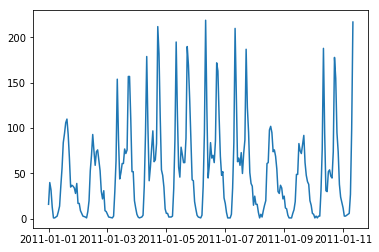

In [4]:
plt.plot(rides.time[:240],rides.cnt[:240])
plt.show()

In [5]:
quant_features = ['temp', 'hum', 'windspeed','t']
x_scaler = StandardScaler()
rides[quant_features] = x_scaler.fit_transform(rides[quant_features].values)

y_scaler = StandardScaler()
rides['cnt'] = y_scaler.fit_transform(rides['cnt'].values[:,None])

rides.head()

/root/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


,temp,hum,windspeed,cnt,time,t,season_2,season_3,season_4,hr_1,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_1,weathersit_2,weathersit_3,weathersit_4
0,-1.334648,0.947372,-1.553889,-0.956339,2011-01-01 00:00:00,-1.745435,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,-1.438516,0.895539,-1.553889,-0.824022,2011-01-01 01:00:00,-1.745236,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,-1.438516,0.895539,-1.553889,-0.868128,2011-01-01 02:00:00,-1.745038,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,-1.334648,0.636370,-1.553889,-0.972879,2011-01-01 03:00:00,-1.744840,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,-1.334648,0.636370,-1.553889,-1.039037,2011-01-01 04:00:00,-1.744641,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


Split into training and testing data

In [6]:
train_data = rides[:-21*24]
test_data = rides[-21*24:]

train_x = train_data.drop(['cnt','time'],axis=1)
test_x = test_data.drop(['cnt','time'],axis=1)

In [1]:
SVR?

Object `SVR` not found.


In [40]:
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# create the sub models
estimators = []
estimators.append(( 'linear' , LinearRegression()))
# TODO: In the same way as above append Random Forst and Support vector machines to `estimators`
# Optional: Change the default parameters in here

for model_name, model in estimators:
    # Do ten fold cross validation
    res = cross_val_score(model, train_x, train_data['cnt'], cv=10, 
                          scoring='neg_mean_squared_error')
    mean_mse = -res.mean()
    stddev_mse = #TODO: get the standard deviation of the result (google numpy standard deviation)
    print(model_name+' : '+str(mean_mse)+' ('+str(stddev_mse)+ ')')

linear : 0.342585931399 (0.148649396312)
Random Forest : 0.161910278435 (0.0623367980617)
svm : 0.222756802956 (0.130537808513)


In [8]:
from xgboost import XGBRegressor

# TODO: Get cross validation score, same as above for XGBoost
model = 
res = cross_val_score(model, train_x, train_data['cnt'], cv=10, 
                          scoring='neg_mean_squared_error')
print('XGBoost : '+str(-res.mean())+' ('+str(res.std())+ ')')

/root/miniconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


XGBoost : 0.230376611932 (0.124462645693)


Keep in mind that you still need to `fit` the model. `cross_val_score` only gets you the cross validation score, nothing more.

In [9]:
model = XGBRegressor()
model.fit(train_x, train_data['cnt'])

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [10]:
pred_y = model. # Todo get the predictions for the test values
error = test_data['cnt'] - pred_y
print(np.mean(np.square(error)))

0.366700817704


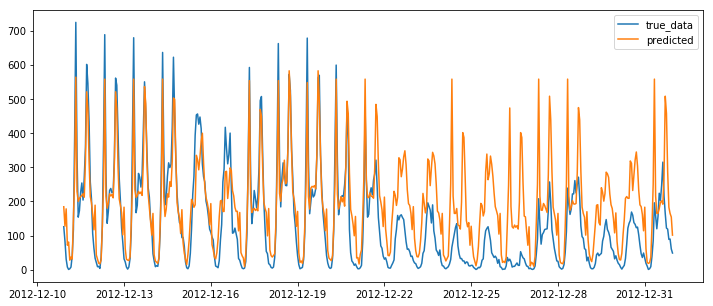

In [11]:
plt.figure(figsize=(12,5))
plt.plot(test_data['time'],y_scaler.inverse_transform(test_data['cnt']), label='true_data')
plt.plot(test_data['time'],y_scaler.inverse_transform(pred_y), label='predicted')
plt.legend()
plt.show()

In [29]:
import xgboost as xgb

xgbTrainData = xgb.DMatrix(train_x.values, train_data.cnt.values, feature_names=train_x.columns.values.tolist())
xgbTestData = xgb.DMatrix(test_x.values, feature_names=train_x.columns.values.tolist())
param = {'max_depth':2, 'objective':'reg:linear', 'eta':0.2}

model = xgb.train(param, xgbTrainData, num_boost_round=30)

In [30]:
pred_y = model.predict(xgbTestData)
error = test_data['cnt'] - pred_y
print(np.mean(np.square(error)))

0.498790857496


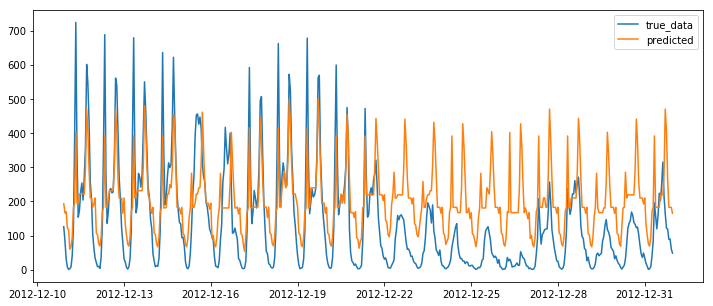

In [31]:
plt.figure(figsize=(12,5))
plt.plot(test_data['time'],y_scaler.inverse_transform(test_data['cnt']), label='true_data')
plt.plot(test_data['time'],y_scaler.inverse_transform(pred_y), label='predicted')
plt.legend()
plt.show()

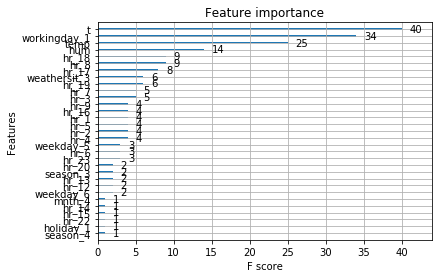

In [25]:
xgb.plot_importance(model)
plt.show()

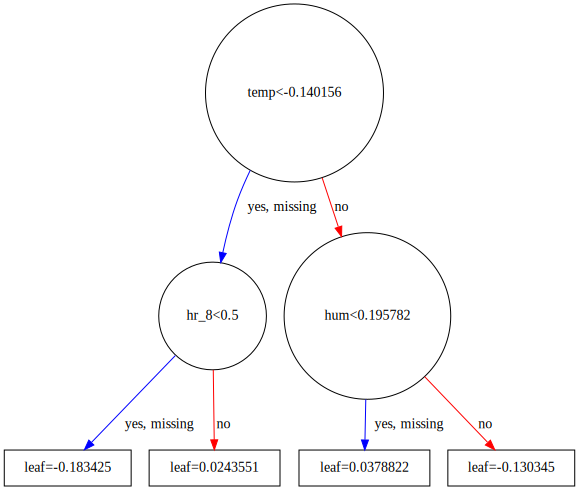

In [45]:
xgb.to_graphviz(model, num_trees=0)

## Best Hyper parameters

Change the number of trees, depth of tree and learning rate to choose best xgboost model.

In [54]:
model = XGBRegressor()

trees = [10,20,30]
depth = # TODO: set an array for a depth of 2,3 or 4
eta = # TODO: set sensible number for a learning parameter

param_grid = dict(max_depth=depth, n_estimators=trees, learning_rate = eta)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=10)

In [55]:
grid_result = grid.fit(train_x, train_data['cnt'])

In [56]:
[grid_result.best_score_, grid_result.best_params_]

[-0.36305377056241572,
 {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 30}]

In [57]:
for params, mean_score, scores in grid_result.grid_scores_:
    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))

-1.180117 (0.255839) with: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 10}
-1.113671 (0.267421) with: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 20}
-1.056985 (0.279776) with: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 30}
-1.162475 (0.252921) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 10}
-1.079815 (0.259127) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 20}
-1.005851 (0.266658) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 30}
-1.140149 (0.242276) with: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 10}
-1.046260 (0.242711) with: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 20}
-0.962281 (0.244874) with: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 30}
-0.793515 (0.326464) with: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 10}
-0.641093 (0.324635) with: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 20}
-0.554971 (0.303945) with: {'learning_rate': 

/root/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [58]:
pred_y = grid.predict(test_x)
error = test_data['cnt'] - pred_y
np.mean(np.square(error))

0.41480160995311177

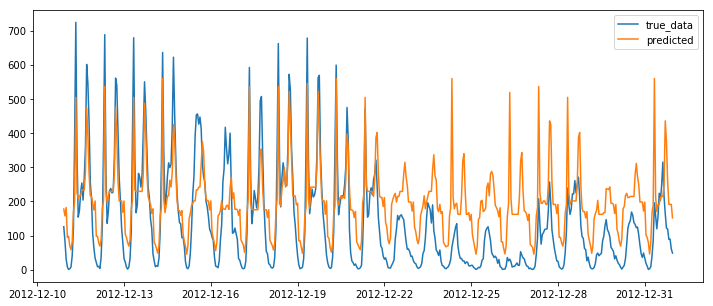

In [59]:
plt.figure(figsize=(12,5))
plt.plot(test_data['time'],y_scaler.inverse_transform(test_data['cnt']), label='true_data')
plt.plot(test_data['time'],y_scaler.inverse_transform(pred_y), label='predicted')
plt.legend()
plt.show()